In [1]:
# Importing necessary packages TEST test
from datetime import date, timedelta
import os
import requests
import shutil
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import tqdm

In [2]:
# Set start date and end date, with 7 days interval
start = date(2020, 1, 3)
end = date.today()
week = timedelta(days=7)

# Creating a list with dates from start to end and 7-days interval
dates_string = []
mydate = start
while mydate < end:
    dates_string.append("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate))
    mydate += week

In [3]:
URL_job_temp = []

# Creating a list with URL's for each week top 200 charts
for i in dates_string[0:-1]:
    URL_job_temp.append(f'https://spotifycharts.com/regional/dk/weekly/{i}--')
    
URL_job= ["{}{}".format(i, j) for i, j in zip(URL_job_temp, dates_string[1:])]

In [4]:
# Finds current directory and makes a new folder 'Spotify_files' and changes directory to 'Spotify_files'
path = os.getcwd()
os.mkdir(f'{path}/Spotify_files')
os.chdir(f'{path}/Spotify_files')

# Downloads every weeks top 200 charts as csv file and place them in the folder 'Spotify_files'.
for i in URL_job:
    url = f'{i}/download'
    r = requests.get(url, verify=False,stream=True)
    if r.status_code!=200:
        print( "Failure")
        exit()
    else:
        r.raw.decode_content = True
        with open(f'{i[45:67]}.csv', 'wb',) as f:
            shutil.copyfileobj(r.raw, f)
        print("Success")

# Changes directory back to original path
os.chdir(path)

FileExistsError: [Errno 17] File exists: '/Users/emmahoumollerveng/ISDS_EEJJ/Spotify_files'

In [5]:
dataframes = []
# Makes a list of the downloaded csv files
for i in URL_job:
    df = pd.read_csv(f'{path}/Spotify_files/{i[45:67]}.csv', header=1)
    df['date'] = i[45:67]
    dataframes.append(df)

# Concatenates all the csv files into a dataframe
combined_csv = pd.concat(dataframes).reset_index(drop=True)

# Slices dates such that they only consist of the first date of the the week
combined_csv['date'] = combined_csv['date'].str.slice(0,10)

# Changes format to datetime
combined_csv['date'] = pd.to_datetime(combined_csv['date'])

# Makes a new variable 'uri', slightly different from URL
combined_csv['uri'] = 'spotify:track:' + combined_csv['URL'].str.slice(31,53)

In [6]:
combined_csv

,Position,Track Name,Artist,Streams,URL,date,uri
0,1,PUB G (feat. Branco & Larry 44),LOLO,613471,https://open.spotify.com/track/0alp0O9d7KTtAF1...,2020-01-03,spotify:track:0alp0O9d7KTtAF1QnBqqiv
1,2,Yummy,Justin Bieber,498327,https://open.spotify.com/track/41L3O37CECZt3N7...,2020-01-03,spotify:track:41L3O37CECZt3N7ziG2z7l
2,3,Blinding Lights,The Weeknd,441317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,2020-01-03,spotify:track:0sf12qNH5qcw8qpgymFOqD
3,4,Kærlighed (feat. Gilli & Kesi),ATYPISK,428895,https://open.spotify.com/track/2xeiAqqHWYXQMWk...,2020-01-03,spotify:track:2xeiAqqHWYXQMWk6s2aQdw
4,5,Dance Monkey,Tones And I,401189,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,2020-01-03,spotify:track:1rgnBhdG2JDFTbYkYRZAku
...,...,...,...,...,...,...,...
6395,196,Thank You [Not So Bad],VIZE,59411,https://open.spotify.com/track/4AqN8IdKCfItCSb...,2020-08-07,spotify:track:4AqN8IdKCfItCSbuaFch81
6396,197,Okay,Tessa,59104,https://open.spotify.com/track/4HtQ1OKauyaDx1j...,2020-08-07,spotify:track:4HtQ1OKauyaDx1jIos6Zmv
6397,198,Plastic (feat. Benjamin Hav),Pind,59099,https://open.spotify.com/track/758P0zO2goHiN3N...,2020-08-07,spotify:track:758P0zO2goHiN3NA5OW1Qe
6398,199,Piece Of Your Heart,MEDUZA,58919,https://open.spotify.com/track/1DFD5Fotzgn6yYX...,2020-08-07,spotify:track:1DFD5Fotzgn6yYXkYsKiGs


In [7]:
# Passes client id and client secret to spotipy
cid = 'e3da1cac4264428cbe476f7d055db765'
secret = 'b87a66e1c3a948d295549023b963f2cb'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [8]:
def get_track_features(id):
    '''Takes an uri, URL or track id and returns a list of lists with some metadata
    and its musical features''' 
    meta = sp.track(id)
    features = sp.audio_features(id)
    
    # Metadata
    name = meta['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    
    # Musical features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    valence = features[0]['valence']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    URL = features[0]['uri']
    track = [name, release_date ,length, danceability, acousticness, energy, instrumentalness, liveness, loudness, speechiness, valence, tempo, time_signature, URL]
    return track

# Running get_track_features function on all tracks
tracks_features = []
for i in tqdm.tqdm(combined_csv['URL']):
    tracks_features.append(get_track_features(i))

  2%|▏         | 102/6400 [00:15<09:45, 10.76it/s]

KeyboardInterrupt: 

In [ ]:
# Converts list of all track features to a dataframe
df = pd.DataFrame(tracks_features, columns = ['name','release_date', 'length', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence','tempo', 'time_signature','uri'])

# Merges dataframe with weekly top 200 charts with dataframe containing all track features. 
# Merge is made on index since the order of the dataframes are similar
combined_csv_joined = pd.merge(combined_csv, df, left_index=True, right_index=True)\
                        .drop('name', axis=1)\
                        .to_csv('songs_and_audio_features.csv')


In [10]:
df2 = pd.read_csv('songs_and_audio_features.csv')
df2

,Unnamed: 0,Position,Track Name,Artist,Streams,URL,date,uri_x,release_date,length,...,acousticness,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,uri_y
0,0,1,PUB G (feat. Branco & Larry 44),LOLO,613471,https://open.spotify.com/track/0alp0O9d7KTtAF1...,2020-01-03,spotify:track:0alp0O9d7KTtAF1QnBqqiv,2019-12-20,159722,...,0.31800,0.586,0.000000,0.1130,-6.834,0.1120,0.297,118.002,4,spotify:track:0alp0O9d7KTtAF1QnBqqiv
1,1,2,Yummy,Justin Bieber,498327,https://open.spotify.com/track/41L3O37CECZt3N7...,2020-01-03,spotify:track:41L3O37CECZt3N7ziG2z7l,2020-01-03,210426,...,0.36600,0.514,0.000000,0.1160,-6.612,0.0897,0.494,145.921,4,spotify:track:41L3O37CECZt3N7ziG2z7l
2,2,3,Blinding Lights,The Weeknd,441317,https://open.spotify.com/track/0sf12qNH5qcw8qp...,2020-01-03,spotify:track:0sf12qNH5qcw8qpgymFOqD,2019-11-29,201573,...,0.00147,0.796,0.000209,0.0938,-4.075,0.0629,0.345,171.017,4,spotify:track:0sf12qNH5qcw8qpgymFOqD
3,3,4,Kærlighed (feat. Gilli & Kesi),ATYPISK,428895,https://open.spotify.com/track/2xeiAqqHWYXQMWk...,2020-01-03,spotify:track:2xeiAqqHWYXQMWk6s2aQdw,2019-11-14,173182,...,0.01300,0.686,0.000000,0.0484,-5.065,0.1140,0.686,114.980,4,spotify:track:2xeiAqqHWYXQMWk6s2aQdw
4,4,5,Dance Monkey,Tones And I,401189,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,2020-01-03,spotify:track:1rgnBhdG2JDFTbYkYRZAku,2019-05-10,209754,...,0.68800,0.593,0.000161,0.1700,-6.401,0.0988,0.540,98.078,4,spotify:track:1rgnBhdG2JDFTbYkYRZAku
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,6395,196,Thank You [Not So Bad],VIZE,59411,https://open.spotify.com/track/4AqN8IdKCfItCSb...,2020-08-07,spotify:track:4AqN8IdKCfItCSbuaFch81,2020-02-07,197963,...,0.20100,0.890,0.000002,0.1010,-4.981,0.1870,0.268,100.037,4,spotify:track:4AqN8IdKCfItCSbuaFch81
6396,6396,197,Okay,Tessa,59104,https://open.spotify.com/track/4HtQ1OKauyaDx1j...,2020-08-07,spotify:track:4HtQ1OKauyaDx1jIos6Zmv,2019-08-23,167404,...,0.00719,0.530,0.000000,0.1100,-9.805,0.2170,0.432,96.993,4,spotify:track:4HtQ1OKauyaDx1jIos6Zmv
6397,6397,198,Plastic (feat. Benjamin Hav),Pind,59099,https://open.spotify.com/track/758P0zO2goHiN3N...,2020-08-07,spotify:track:758P0zO2goHiN3NA5OW1Qe,2019-11-15,183387,...,0.25200,0.664,0.000000,0.1000,-4.774,0.0647,0.531,123.997,4,spotify:track:758P0zO2goHiN3NA5OW1Qe
6398,6398,199,Piece Of Your Heart,MEDUZA,58919,https://open.spotify.com/track/1DFD5Fotzgn6yYX...,2020-08-07,spotify:track:1DFD5Fotzgn6yYXkYsKiGs,2019-02-01,152913,...,0.04040,0.744,0.000160,0.0740,-6.806,0.0295,0.631,124.080,4,spotify:track:1DFD5Fotzgn6yYXkYsKiGs


In [99]:
musical_variables =  ["danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]

In [38]:
df_split2 = df2[["date", "danceability", "acousticness", "energy", "instrumentalness", "liveness","speechiness", "valence"]]
df_group = df_split2.groupby(by = 'date').mean()
df_group

,danceability,acousticness,energy,instrumentalness,liveness,speechiness,valence
date,,,,,,,
2020-01-03,0.707995,0.238671,0.597610,0.006678,0.155639,0.129560,0.477867
2020-01-10,0.710845,0.239687,0.600555,0.007528,0.154313,0.130853,0.485048
2020-01-17,0.712750,0.231822,0.602603,0.007429,0.163217,0.140488,0.481004
2020-01-24,0.716430,0.244469,0.592355,0.007291,0.157716,0.133745,0.486408
2020-01-31,0.725465,0.239185,0.588030,0.007401,0.148388,0.142834,0.493196
2020-02-07,0.719340,0.238284,0.598420,0.007413,0.153662,0.128677,0.495268
2020-02-14,0.707510,0.269546,0.584005,0.009012,0.157007,0.142529,0.501207
2020-02-21,0.709765,0.262666,0.587870,0.005900,0.157695,0.139616,0.502453
2020-02-28,0.719190,0.242300,0.598240,0.006598,0.159943,0.137181,0.500848


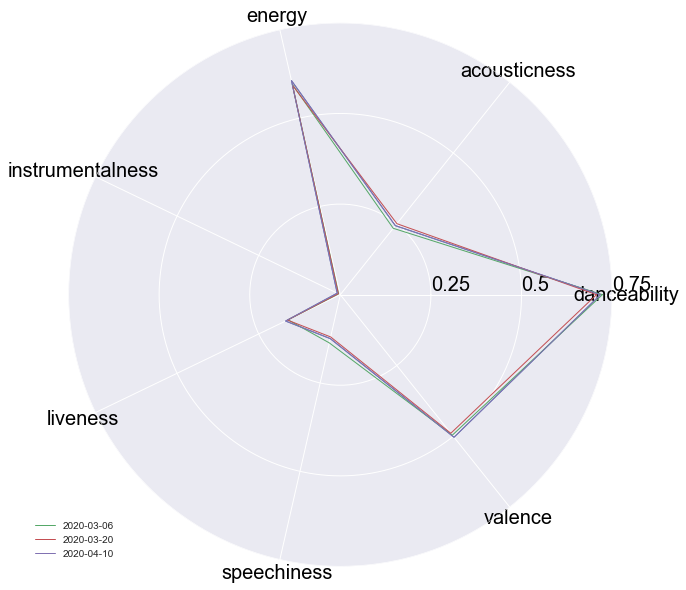

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
plt.style.use("seaborn")
 
# Set data
'''df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})'''
 
# number of variable
categories=musical_variables
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
#values=df_group.loc['2020-01-03'].values.flatten().tolist()
#values += values[:1]
#values

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=20)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="black", size=20)
plt.ylim(0,0.75)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
#ax.fill(angles, values, 'b', alpha=0.1)

values=df_group.loc['2020-03-06'].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2020-03-06")
#ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df_group.loc['2020-03-20'].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2020-03-20")
#ax.fill(angles, values, 'r', alpha=0.1)

# Ind2
values=df_group.loc['2020-04-10'].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2020-04-10")
#ax.fill(angles, values, 'r', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1,0.1))

In [ ]:
'''# Definining functions 
def get_artist(name):
    # Returns the artist object with respective data
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None
def get_artist_albums_ids(artist):
    # Given an artist object, returns a list of with each of the album's ids
    albums_ids = []
    for i in range (len(sp.artist_albums(artist['id'], album_type='album',limit=50)['items'])):
        albums_ids.append(sp.artist_albums(artist['id'], album_type='album',limit=50)['items'][i]['id'])
    return albums_ids
def filter_albums_ids(albums_ids):
    # Spotify has many versions of the same album. 
    # This function filters a list of albums ids and returns the most popular ones
    album_names = []    
    for album_id in albums_ids:
        album_names.append(sp.album(album_id)['name'])       
    album_pop = []    
    for album_id in albums_ids:
        album_pop.append(sp.album(album_id)['popularity'])    
    d = {'id': albums_ids,'name': album_names, 'popularity': album_pop}
    df = pd.DataFrame(data=d)    
    df = df.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
    df = df.reset_index(drop = True)   
    return (df['id'])
def get_artist_albums_tracks_ids(albums_ids):
    # Given a list of albums ids, returns a list of ids of the albums' tracks
    tracks_ids = []
    for album_id in albums_ids:
        for i in range(len(sp.album_tracks(album_id)['items'])):
            tracks_ids.append(sp.album_tracks(album_id)['items'][i]['id'])
    return(tracks_ids)
def get_track_features(id):
    # Given a track id, returns a nested list with its musical features as described in the introduction
    meta = sp.track(id)
    features = sp.audio_features(id)
    # Meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']
    # Features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    valence = features[0]['valence']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    track = [name, album, artist, release_date, length, popularity, danceability, acousticness, energy, instrumentalness, liveness, loudness, speechiness, valence, tempo, time_signature]
    return track
def get_tracks_features(tracks_ids):
    # given a list of ids of tracks, returns a list with their features
    tracks = []
    for i in range(0, len(tracks_ids)):
        track = get_track_features(tracks_ids[i])
        tracks.append(track)
    return(tracks)
def tracks_features_to_csv(tracks_features, csv_title):
    # transforms the list of track features into a csv file
    df = pd.DataFrame(tracks_features, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence','tempo', 'time_signature'])
    df.to_csv(csv_title + ".csv", sep = ',')
def get_discography(artist_name):
    # a function that returns the discography of an artist given its name (string)
    # do not use, it is quite unreliable since the discography is not filtered
    tracks_features = get_tracks_features(get_artist_albums_tracks_ids(filter_albums_ids(get_artist_albums_ids(get_artist(artist_name)))))
    return tracks_features_to_csv(tracks_features, artist_name)
def get_playlist_track_ids(user, playlist_id):
    # initially I wanted to use a playlist to get an artist's discography
    # however, finding a good playlist proved to be quite difficult
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids'''